## Usage Cost Analysis

This notebook analyzes usage data from all CSV files in the data folder, providing breakdowns by year, month, and week, along with cost trends.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Set figure size for better readability
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'white'

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [13]:
# Load all CSV files from the data folder
import os
import glob

data_folder = "data"
csv_files = glob.glob(os.path.join(data_folder, "*.csv"))

# Load and combine all CSV files
all_dataframes = []
for csv_file in csv_files:
    print(f"Loading: {csv_file}")
    df_temp = pd.read_csv(csv_file, parse_dates=["Date"])
    all_dataframes.append(df_temp)

# Combine all dataframes
df = pd.concat(all_dataframes, ignore_index=True)

# Extract date components
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week
df["YearMonth"] = df["Date"].dt.to_period("M")
df["YearWeek"] = df["Year"].astype(str) + "-W" + df["Week"].astype(str).str.zfill(2)

print(f"\nDataset Shape: {df.shape}")
print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Unique models: {df['Model'].nunique()}")
print(f"Total Cost: ${df['Cost'].sum():.2f}")
print(f"Total Tokens: {df['Total Tokens'].sum():,}")
df.head()

Loading: data\usage-events-2026-01-18.csv

Dataset Shape: (71, 15)
Date Range: 2026-01-15 01:57:50.350000+00:00 to 2026-01-18 05:35:12.578000+00:00
Unique models: 4
Total Cost: $11.95
Total Tokens: 27,907,321


,Date,Kind,Model,Max Mode,Input (w/ Cache Write),Input (w/o Cache Write),Cache Read,Output Tokens,Total Tokens,Cost,Year,Month,Week,YearMonth,YearWeek
0,2026-01-18 05:35:12.578000+00:00,Included,auto,No,52056,109492,137486,21813,320847,0.37,2026,1,3,2026-01,2026-W03
1,2026-01-18 05:25:01.931000+00:00,Included,auto,No,2360,0,104704,454,107518,0.03,2026,1,3,2026-01,2026-W03
2,2026-01-18 05:22:45.622000+00:00,Included,auto,No,23185,0,458240,7549,488974,0.19,2026,1,3,2026-01,2026-W03
3,2026-01-18 05:18:32.168000+00:00,Included,auto,No,23801,9971,283136,9121,326029,0.17,2026,1,3,2026-01,2026-W03
4,2026-01-18 04:49:53.240000+00:00,Included,auto,No,505,0,65024,180,65709,0.02,2026,1,3,2026-01,2026-W03


In [14]:
# Year breakdown
yearly = df.groupby('Year').agg({
    'Cost': 'sum',
    'Total Tokens': 'sum',
    'Date': 'count'
}).rename(columns={'Date': 'Event Count'})

print("=== Year Breakdown ===")
yearly['Cost (USD)'] = yearly['Cost']
print(yearly[['Cost (USD)', 'Total Tokens', 'Event Count']])
print()

=== Year Breakdown ===
      Cost (USD)  Total Tokens  Event Count
Year                                       
2026      11.946      27907321           71



In [15]:
# Monthly breakdown
monthly = df.groupby('YearMonth').agg({
    'Cost': 'sum',
    'Total Tokens': 'sum',
    'Date': 'count'
}).rename(columns={'Date': 'Event Count'})
monthly = monthly.sort_index()

monthly['Cost (USD)'] = monthly['Cost']
monthly['Cost per Event'] = (monthly['Cost'] / monthly['Event Count']).round(3)
monthly['Tokens per Event'] = (monthly['Total Tokens'] / monthly['Event Count']).round(0)

print("=== Monthly Breakdown ===")
print(monthly[['Cost (USD)', 'Total Tokens', 'Event Count', 'Cost per Event', 'Tokens per Event']])
print()

=== Monthly Breakdown ===
           Cost (USD)  Total Tokens  Event Count  Cost per Event  \
YearMonth                                                          
2026-01        11.946      27907321           71           0.168   

           Tokens per Event  
YearMonth                    
2026-01            393061.0  



In [16]:
# Weekly breakdown
weekly = df.groupby('YearWeek').agg({
    'Cost': 'sum',
    'Total Tokens': 'sum',
    'Date': 'count'
}).rename(columns={'Date': 'Event Count'})
weekly = weekly.sort_index()

weekly['Cost (USD)'] = weekly['Cost']
weekly['Cost per Event'] = (weekly['Cost'] / weekly['Event Count']).round(3)

print("=== Weekly Breakdown ===")
print(weekly[['Cost (USD)', 'Total Tokens', 'Event Count', 'Cost per Event']])
print()

=== Weekly Breakdown ===
          Cost (USD)  Total Tokens  Event Count  Cost per Event
YearWeek                                                       
2026-W03      11.946      27907321           71           0.168



In [17]:
# Cost breakdown by Model
model_breakdown = df.groupby('Model').agg({
    'Cost': 'sum',
    'Total Tokens': 'sum',
    'Date': 'count'
}).rename(columns={'Date': 'Event Count'})
model_breakdown = model_breakdown.sort_values('Cost', ascending=False)

model_breakdown['Cost (USD)'] = model_breakdown['Cost']
model_breakdown['Tokens (M)'] = (model_breakdown['Total Tokens'] / 1_000_000).round(2)
model_breakdown['Cost %'] = (model_breakdown['Cost'] / df['Cost'].sum() * 100).round(1)

print("=== Cost Breakdown by Model ===")
print(model_breakdown[['Cost (USD)', 'Tokens (M)', 'Event Count', 'Cost %']])
print()

=== Cost Breakdown by Model ===
                               Cost (USD)  Tokens (M)  Event Count  Cost %
Model                                                                     
auto                                9.440       24.21           49    79.0
claude-4.5-sonnet-thinking          1.560        1.34            7    13.1
claude-4.5-opus-high-thinking       0.750        0.51            2     6.3
gpt-5.1-codex-mini                  0.196        1.84           13     1.6



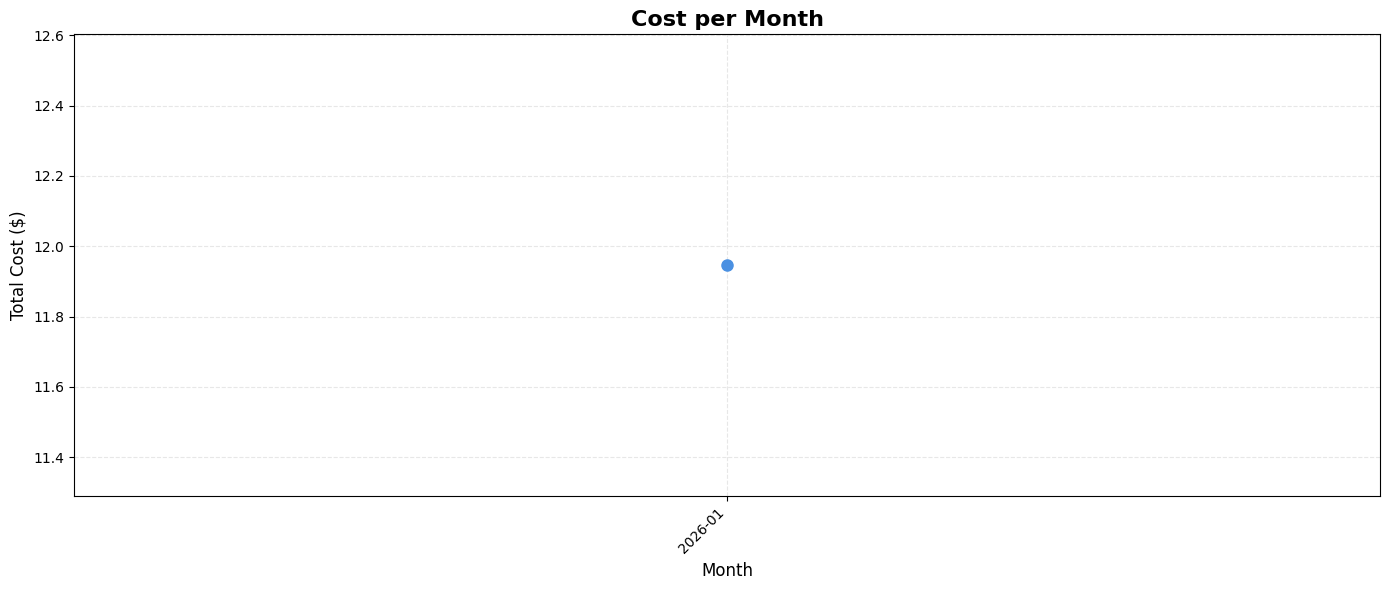

In [18]:
# Line chart: Cost per Month
plt.figure(figsize=(14, 6))
monthly_dates = monthly.index.astype(str)
plt.plot(monthly_dates, monthly['Cost (USD)'], marker='o', linewidth=2, markersize=8, color='#4a90e2')
plt.title('Cost per Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Cost ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [19]:
# Summary statistics
total_cost = df['Cost'].sum()
total_tokens = df['Total Tokens'].sum()
total_events = len(df)

print("=== Summary Statistics ===")
print(f"Total Cost: ${total_cost:.2f}")
print(f"Total Tokens: {total_tokens:,}")
print(f"Total Events: {total_events}")
print(f"Average Cost per Event: ${df['Cost'].mean():.4f}")
print(f"Average Tokens per Event: {df['Total Tokens'].mean():,.0f}")
print(f"\nDate Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Number of Months: {monthly.shape[0]}")
print(f"Number of Weeks: {weekly.shape[0]}")

=== Summary Statistics ===
Total Cost: $11.95
Total Tokens: 27,907,321
Total Events: 71
Average Cost per Event: $0.1683
Average Tokens per Event: 393,061

Date Range: 2026-01-15 to 2026-01-18
Number of Months: 1
Number of Weeks: 1
